In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


plt.style.use("seaborn-v0_8-darkgrid")

In [2]:
df = pd.read_csv("../data/Pecan_1/pecan_1_min_part1.csv", parse_dates=["localminute"])
df

,localminute,dataid,use
0,2016-01-01 00:00:00-06:00,26,0.519
1,2016-01-01 00:00:00-06:00,59,1.176
2,2016-01-01 00:00:00-06:00,86,0.469
3,2016-01-01 00:00:00-06:00,114,1.006
4,2016-01-01 00:00:00-06:00,370,0.519
...,...,...,...
2421811,2016-04-30 05:57:00-05:00,101,0.324
2421812,2016-04-30 05:58:00-05:00,101,0.323
2421813,2016-04-30 05:58:00-05:00,86,0.464
2421814,2016-04-30 05:59:00-05:00,86,0.464


In [3]:
cid = 26
df = df[df["dataid"] == cid].copy()

In [4]:
df = df.rename(columns={
    "localminute": "ds",
    "use": "y"
})
df

,ds,dataid,y
0,2016-01-01 00:00:00-06:00,26,0.519
19,2016-01-01 00:01:00-06:00,26,0.519
38,2016-01-01 00:02:00-06:00,26,0.518
42,2016-01-01 00:03:00-06:00,26,0.519
63,2016-01-01 00:04:00-06:00,26,0.518
...,...,...,...
2421590,2016-04-30 04:37:00-05:00,26,0.510
2421596,2016-04-30 04:38:00-05:00,26,0.538
2421601,2016-04-30 04:39:00-05:00,26,0.506
2421604,2016-04-30 04:40:00-05:00,26,0.000


In [5]:
df["ds"] = pd.to_datetime(df["ds"], utc=True)
df = (
    df.set_index('ds')
    .resample("h")
    .agg({"y" : "mean"})
    .reset_index()
)
df

,ds,y
0,2016-01-01 06:00:00+00:00,0.527133
1,2016-01-01 07:00:00+00:00,0.463150
2,2016-01-01 08:00:00+00:00,0.497000
3,2016-01-01 09:00:00+00:00,0.498317
4,2016-01-01 10:00:00+00:00,0.445383
...,...,...
2879,2016-04-30 05:00:00+00:00,0.412917
2880,2016-04-30 06:00:00+00:00,1.417400
2881,2016-04-30 07:00:00+00:00,0.895467
2882,2016-04-30 08:00:00+00:00,0.641883


In [6]:
df["hour"] = df["ds"].dt.hour
df["weekday"] = df["ds"].dt.weekday
df["month"] = df["ds"].dt.month
df["is_weekend"] = df["weekday"].isin([5,6]).astype(int)

df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

df["lag_1"] = df["y"].shift(1)
df["lag_24"] = df["y"].shift(24)
df["lag_168"] = df["y"].shift(168)

df["rolling_mean_3"] = df["y"].shift(1).rolling(3).mean()
df["rolling_mean_24"] = df["y"].shift(1).rolling(24).mean()

df = df.dropna().reset_index(drop=True)

In [7]:
split_idx = int(len(df)*0.8)

train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

In [8]:
features = [
    "hour", "weekday", "month", "is_weekend",
    "hour_sin", "hour_cos",
    "lag_1", "lag_24", "lag_168",
    "rolling_mean_3", "rolling_mean_24"
]

X_train = train_df[features]
X_test = test_df[features]

y_train = train_df["y"]
y_test = test_df["y"]

In [9]:
# LGBM model.
lgbm_residential = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgbm_residential.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1352
[LightGBM] [Info] Number of data points in the train set: 2172, number of used features: 11
[LightGBM] [Info] Start training from score 0.861094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,6
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [10]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

y_pred = lgbm_residential.predict(X_test)

mae, rmse = evaluate(y_test, y_pred)
print(f"Residential-trained Model → MAE: {mae:.3f}, RMSE: {rmse:.3f}")

Residential-trained Model → MAE: 0.410, RMSE: 0.686


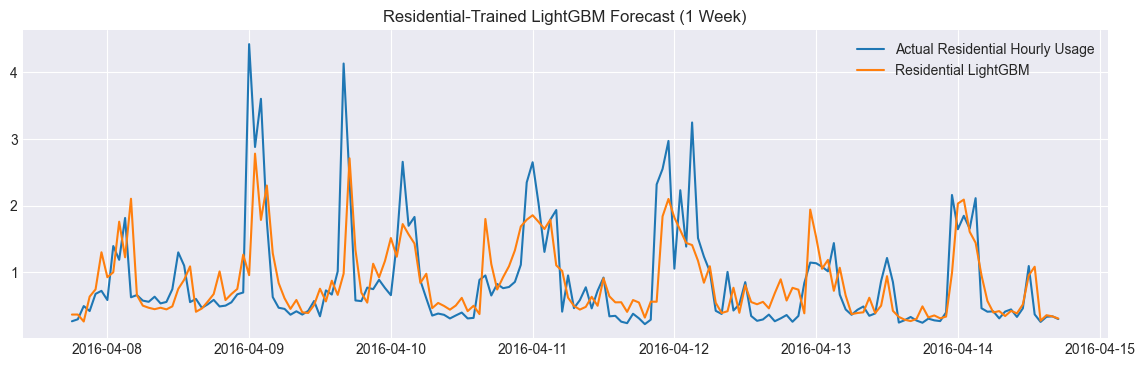

In [11]:
plt.figure(figsize=(14,4))

plt.plot(test_df.ds[:168], y_test.values[:168], label="Actual Residential Hourly Usage")
plt.plot(test_df.ds[:168], y_pred[:168], label="Residential LightGBM")

plt.title("Residential-Trained LightGBM Forecast (1 Week)")
plt.legend()
plt.show()

In [12]:
results = pd.DataFrame({
    "Model": [
        "Delhi-trained (on Residential)",
        "Residential-trained"
    ],
    "MAE": [
        1541.15,
        mae
    ],
    "RMSE": [
        1547.54,
        rmse
    ]
})

results

,Model,MAE,RMSE
0,Delhi-trained (on Residential),1541.150000,1547.540000
1,Residential-trained,0.409884,0.686081


The LightGBM model failed to generalize across domains when applied without retraining; however, retraining the same architecture on residential data restored performance, confirming that the limitation was domain mismatch rather than model capacity.

In [14]:
df.to_csv("../results/Residential_processed.csv", index=False)
print('Saved processed residential data.')

Saved processed residential data.
